# Imports

In [23]:
using JLD2
using PyPlot
using CSV
using ProgressMeter
using DataFrames
using Statistics
using StatsBase
using Distributions
using Distances
using Graphs
using GraphPlot
using Combinatorics
using ColorSchemes
using GraphRecipes, Plots

include("../src/modelisation.jl")
using .colocalization_modelisation

In [2]:
function pad_right(arr::AbstractVector, pad_length::Int, pad_value=0)
    n = length(arr)
    if pad_length <= n
        return arr[1:pad_length]
    else
        return vcat(arr, fill(pad_value, pad_length - n))
    end
end

pad_right (generic function with 2 methods)

In [3]:
parameters_path = "/home/floric/Documents/julia/Random co-localization simulation/output/sampling=100000_replicates=1/colocalization_simulation_parameters.csv"
result_path = "/home/floric/Documents/julia/Random co-localization simulation/output/sampling=100000_replicates=1/"
pairwise_filename = "colocalization_pairwise_counts.jld2"
truth_table_filename = "colocalization_truth_table.jld2"
output_path = "/home/floric/Documents/julia/"

"/home/floric/Documents/julia/"

## Co-localization array

In [4]:
pairwise_data = jldopen(result_path*pairwise_filename, "r") do file
    read(file,"colocalization_counts")
end
simulation_number, distribution_number,_ = size(pairwise_data)

(100000, 7, 7)

In [5]:
truth_table, truth_table_index,cell_shape = jldopen(result_path*truth_table_filename, "r") do file
    println(keys(file))
    read(file,"colocalization_truth_table"), read(file,"colocalization_truth_table_index"), read(file, "shape")
end
simulation_number,spot_per_simulation, distribution_number = size(truth_table)
print("truth_table : ", size(truth_table))
print("truth_table_index : ", size(truth_table_index))

["colocalization_truth_table", "colocalization_truth_table_index", "shape"]
truth_table : (100000, 1510, 7)truth_table_index : (1510,)

## Parameters frame

In [6]:
parameters = sort(CSV.read(parameters_path, DataFrame))
parameters

Row,distribution_id,abudancy
,Int64,Int64
1,1,10
2,2,50
3,3,100
4,4,200
5,5,250
6,6,400
7,7,500


In [7]:
volume = prod(cell_shape)

24964

# Model testing for pairs

### Parametric boostrap

In [54]:
function posterior_predictive_check(expectancy :: Real, std :: Real, data :: Vector, simulation_number = 10000, metric= mean)
    expected_distribution = Normal(expectancy, std)
    sample_size = length(data)

    T_obs = metric(data)
    
    sim_stats = Array{Float64,1}(undef,simulation_number)
    for sim in 1:simulation_number
        y_rep = rand(expected_distribution, sample_size)
        sim_stats[sim] = metric(y_rep)
    end
    println(sim_stats)
    
    return mean(sim_stats .>= T_obs)
end

posterior_predictive_check (generic function with 3 methods)

In [55]:
distribution_query = 7
distribution_anchor = 6
abundancy1 = parameters[distribution_query, "abudancy"]
abundancy2 = parameters[distribution_anchor, "abudancy"]


data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)
data = reshape(data, length(data))

expectancy = colocalization_modelisation.colocalization_expectancy(
    abundancy1,
    abundancy2,
    volume
)
distrib_std = colocalization_modelisation.colocalization_std(
    abundancy1,
    abundancy2,
    volume
)

posterior_predictive_check(expectancy, distrib_std, data, 10000, mean)



0.8261

### Parametric boostrap using Chi square distance (Goodness of fit PPC)

To gain confidence the capacity of our model to predict data that follow random co-localization (**i.e. null hypothesis is true**) we perform a prior predictive check.

* First we transform simulation results into a histogram we consider as the observed distribution. (#TODO relaunch simulation and create different replicates using a sampling number consistent with experimentation : *N ~ 100*)  

* Second using same bining as found for observed data (1 bin per frequency found in experiment) calculate expected weights of bins in a normalised distribution  

* Third, sampling accordingly to simulation and experimentation, create simulated replicates and calcul chi square distance to expected weights (distance qualifying similarity of frequency based distribution). The 99th quantile of this distance measurement (discrepancy) is taken as the critical discrepancy. This indicates the distance up to which a distribution still finds itself behaving under the null hypothesis at significance 1%. In other words only 1% of distributions generated under the null hypothesis find themself with a discrepancy higher than the critical value  

* Calcul discrepancy of observed data to expected distribution under the null and see if it pass the test.  

***Note : this test aims at gaining confidence into the fact that the model can be used to predict data that fits correctly data that randomly co-localize; it is not a guarantee that randomly co-localizing molecules perfectly follows the behavior described in the model. However, it shows that using this model to normalize data across cells should be consistant.***


In [ ]:
"""Create bins that have a uniform probability under null distribution : for N bins p= 1/N for any bin"""
function probability_uniform_binning(expectancy :: Real, std_value :: Real, bin_number = 30)
    expected_distribution = Normal(expectancy, std_value)
    
    # compute the K+1 equally‐spaced quantiles between 0 and 1
    ps = range(0, 1; length=bin_number)
    # invert the CDF at each
    edges = quantile.(Ref(expected_distribution), ps)
    return edges
end


probability_uniform_binning

In [ ]:
"""Expected weights from model for given set of bins (`edges`)"""
function compute_expected_weights(expectancy::Real, std_value::Real, edges)
    distribution_under_null = Normal(expectancy, std_value)
    bin_number = length(edges) - 1
    
    expected_weights = Array{Float64, 1}(undef, bin_number)
    for bin in 1:bin_number
        expected_weights[bin] = cdf(distribution_under_null, edges[bin+1]) - cdf(distribution_under_null, edges[bin])
    end

    return expected_weights
end

compute_expected_weights

In [ ]:
"""Compute discrepancies from null distribution (model distribution) this is usefull to build a confidence interval to test on."""
function compute_chisq_discrepancies_from_null(expectancy :: Real, std_value :: Real, sampling_number ::Int, edges, simulation_number = 100000)
    distribution_under_null = Normal(expectancy, std_value)

    expected_weights = compute_expected_weights(expectancy, std_value, edges)

    discrepancies = Array{Float64, 1}(undef, simulation_number)
    for sim in 1:simulation_number
        simulated_hist = fit(
            Histogram,
            rand(distribution_under_null, sampling_number),
            edges
        )
        discrepancies[sim] = chisq_dist(expected_weights, simulated_hist.weights / sampling_number)
    end
    return discrepancies
end
    

compute_discrepancies_from_null

### Boostrap PPC : significance colormap

Is shown pvalue : $p = 1-\alpha$ with $\alpha$ best significance passed

In [ ]:
distribution_query = 7
distribution_anchor = 5

test_truth_table = Array{Bool, 2}(undef, distribution_number,distribution_number)
chisq_pvalue_table = Array{Float64, 2}(undef, distribution_number,distribution_number)
@showprogress for distribution_query in 1:distribution_number
for distribution_anchor in 1:distribution_number

    abundancy1 = parameters[distribution_query, "abudancy"]
    abundancy2 = parameters[distribution_anchor, "abudancy"]
    sampling_number = 100 # Note :this will change the power of the test, numerically we can take a very high sampling number but test will be too strong. What is useful is to take something relevant to sample number if future experiment i.e. number of cells per replicate
    
    
    data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)
    data = reshape(data, length(data))
    
    expectancy = colocalization_modelisation.colocalization_expectancy(
        abundancy1,
        abundancy2,
        volume
    )
    distrib_std = colocalization_modelisation.colocalization_std(
        abundancy1,
        abundancy2,
        volume
    )
    data_hist = fit(Histogram, data, nbins=maximum(data) + 1)
    binning = data_hist.edges[1]
    expected_weights = compute_expected_weights(expectancy, distrib_std, binning)
    
    discrepancies = compute_discrepancies_from_null(expectancy, distrib_std, sampling_number, binning)
    discrepancies_critical = quantile(discrepancies, 0.95)
    
    data_discrepancies = chisq_dist(expected_weights, data_hist.weights / sum(data_hist.weights))

    test_truth_table[distribution_query, distribution_anchor] = data_discrepancies < discrepancies_critical #Sucess when we fail to reject null hypothesis
    chisq_pvalue_table[distribution_query, distribution_anchor] = mean(data_discrepancies .< discrepancies )

end
end

1 .- chisq_pvalue_table

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


7×7 Matrix{Float64}:
 1.0  1.0      1.0      1.0      1.0      1.0      1.0
 1.0  1.0      1.0      0.9998   0.99937  0.98667  0.96083
 1.0  1.0      1.0      0.98636  0.96007  0.72675  0.57064
 1.0  0.99985  0.98596  1.0      0.57783  0.27785  0.16454
 1.0  0.9992   0.9582   0.57234  1.0      0.17565  0.10755
 1.0  0.98637  0.71695  0.26623  0.17006  1.0      0.00068
 1.0  0.95684  0.54299  0.15171  0.09795  0.00068  1.0

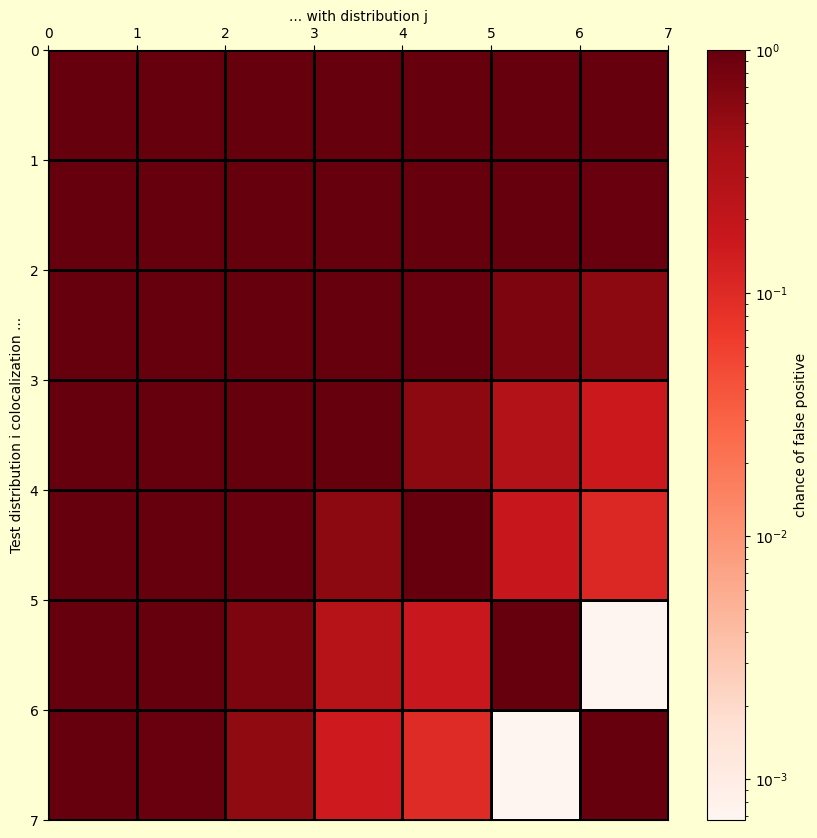

In [76]:
PyPlot.close()
fig = PyPlot.figure(figsize=(10,10), facecolor= "xkcd:eggshell")
ax = fig.gca()

colormesh = ax.pcolormesh(
    1 .- test_pvalue_table,
    norm = matplotlib[:colors][:LogNorm](),
    edgecolors="black",
    cmap= "Reds"
    )
cbar = PyPlot.colorbar(colormesh, label="chance of false positive")


ax.set_ylabel("Test distribution i colocalization ...")
ax.invert_yaxis()

ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
ax.set_xlabel("... with distribution j")


fig

### Overlay simulation and model histograms 

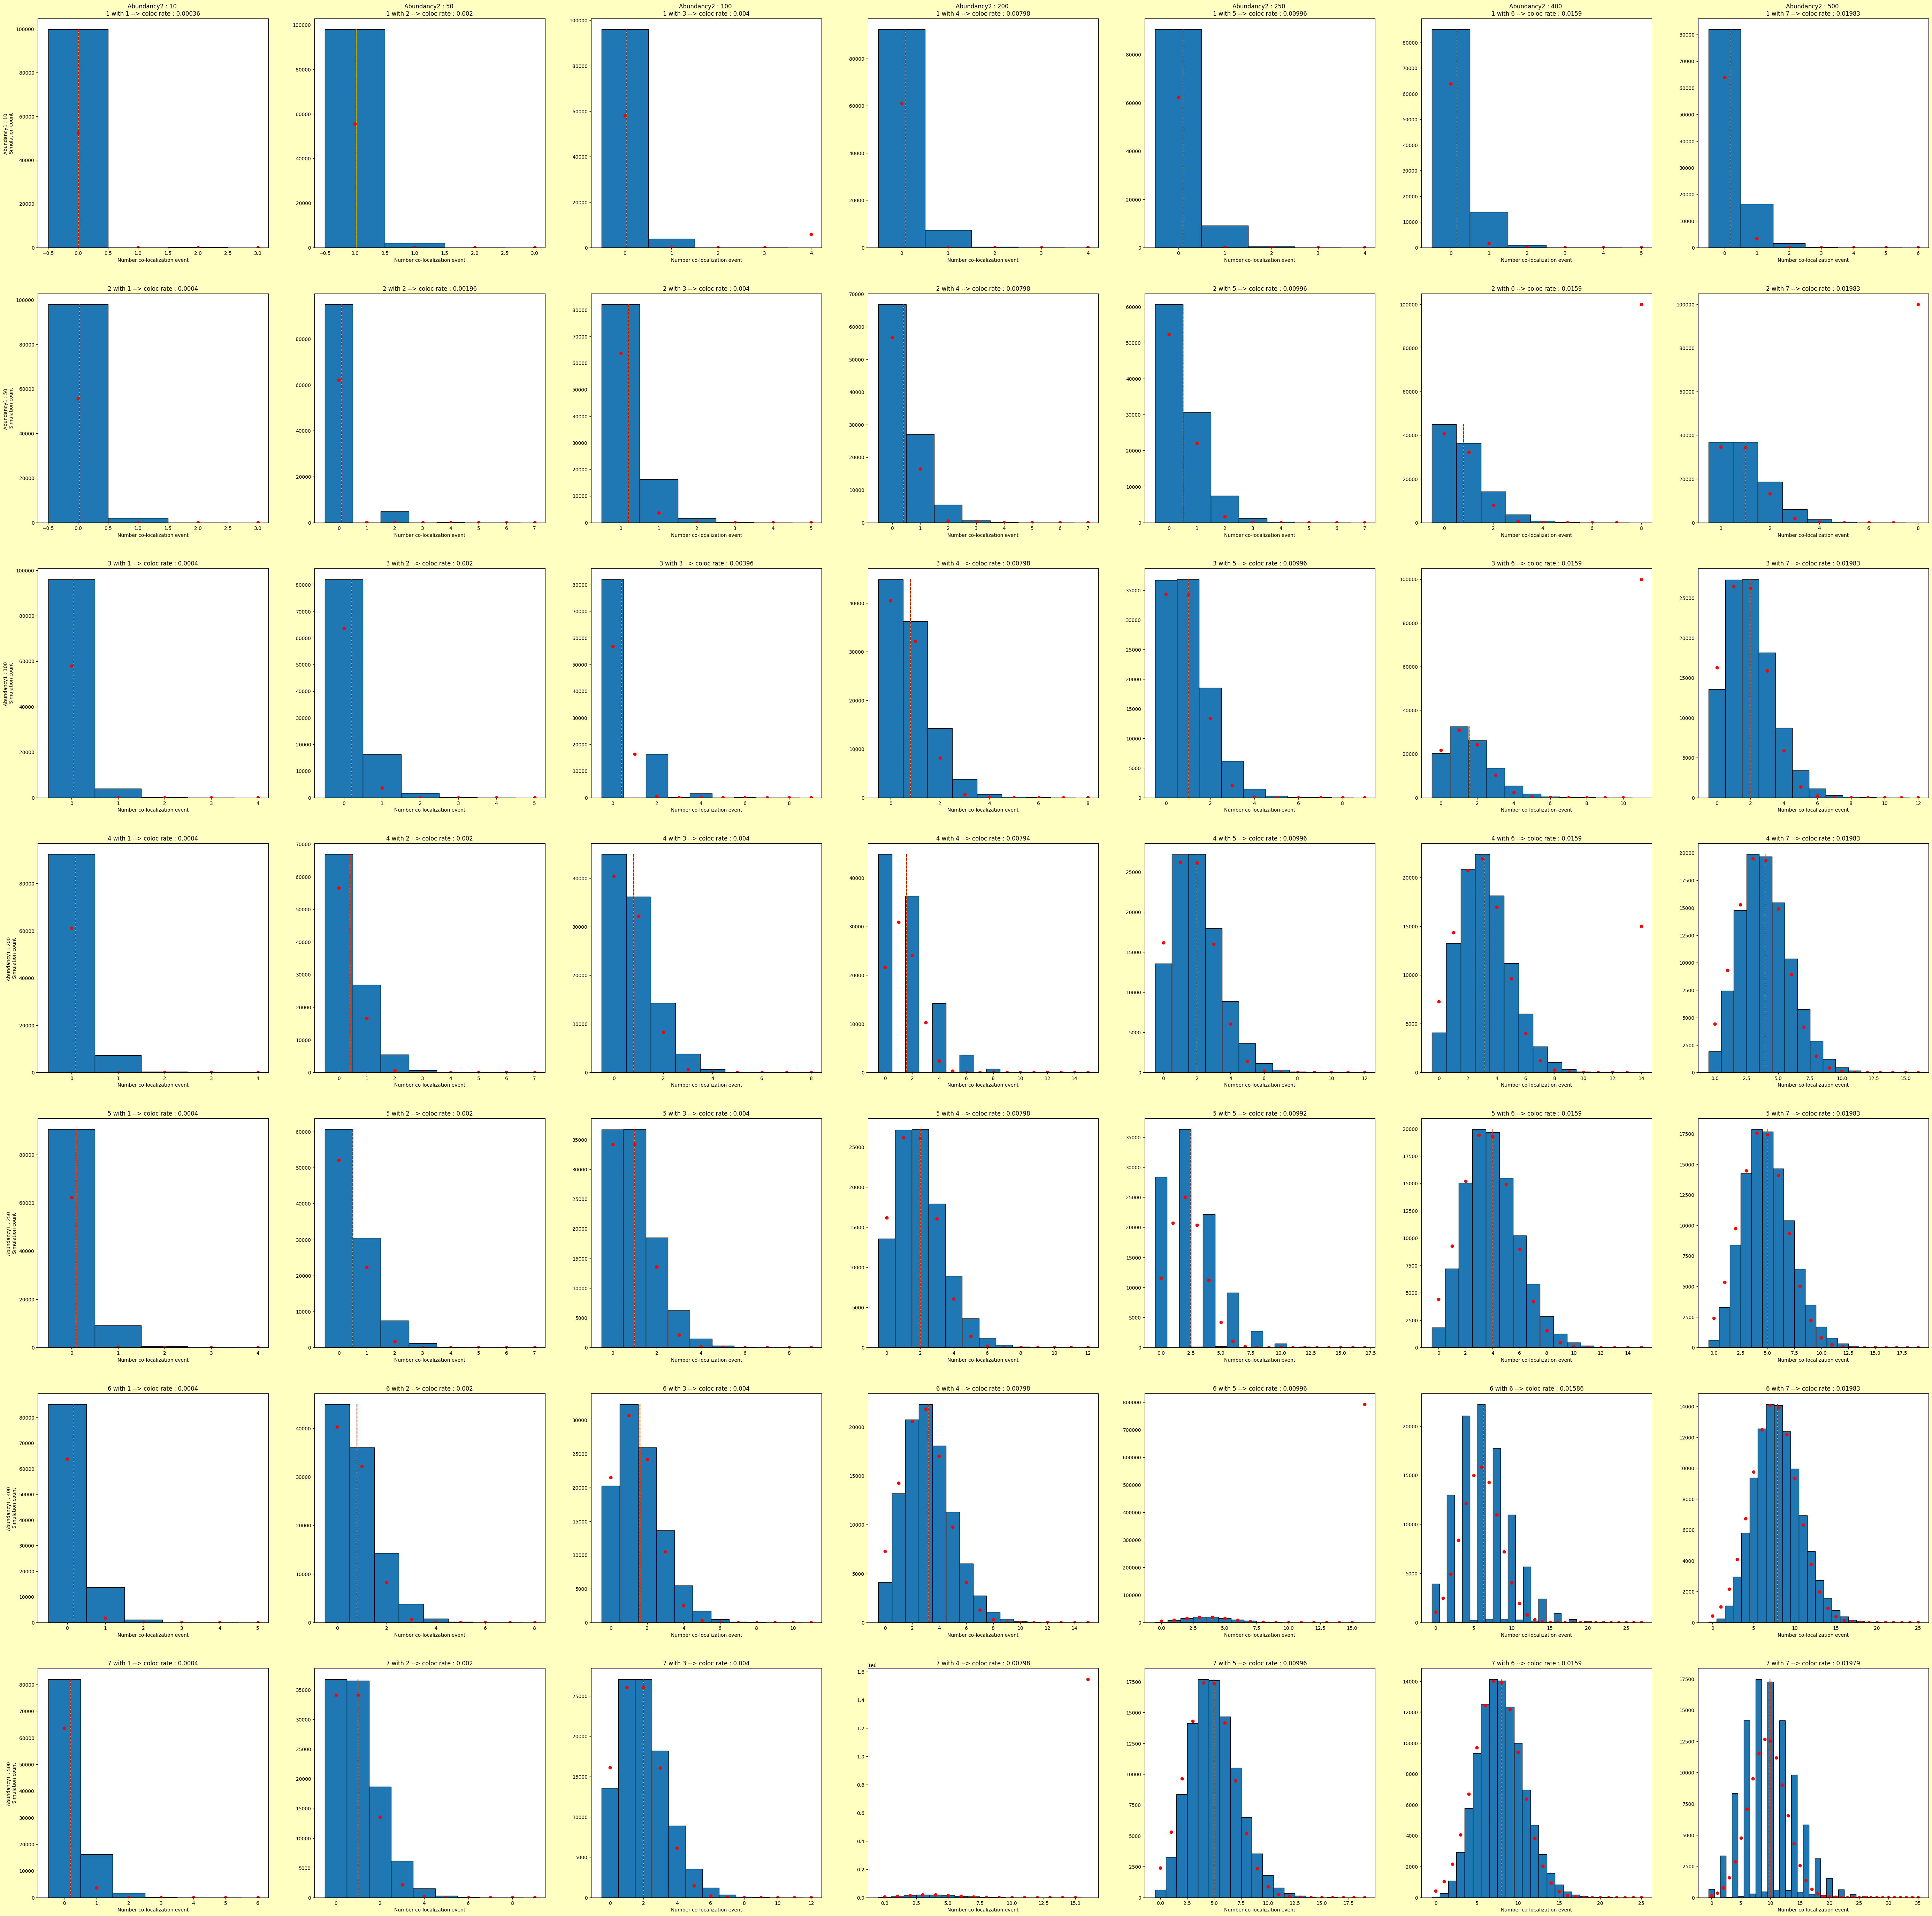

In [69]:
fig, all_axes = subplots(distribution_number,distribution_number, 
figsize=(70,70),
facecolor = "xkcd:cream"
)

ax_idx = 1
for col in 1:distribution_number
    for line in 1:distribution_number
        distribution_query = line
        distribution_anchor = col
        
        abundancy1 = parameters[distribution_query, "abudancy"]
        abundancy2 = parameters[distribution_anchor, "abudancy"]

        if distribution_anchor == distribution_query
            expectancy = colocalization_modelisation.self_colocalization_expectancy(
                abundancy1,
                volume
            )
            std_value = colocalization_modelisation.self_colocalization_std(
                abundancy1,
                volume
            )

        else
            expectancy = colocalization_modelisation.colocalization_expectancy(
                abundancy1,
                abundancy2,
                volume
            )
            std_value = colocalization_modelisation.colocalization_std(
                abundancy1,
                abundancy2,
                volume
            )
        end
        
        expected_distribution = Normal(expectancy, std_value)

        data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)

        #Plotting
        ax = all_axes[ax_idx]

        counts, bins = ax.hist(
            data, 
            bins = 0:maximum(data) + 1, 
            align= "left",
            edgecolor = "black",
            density=0
            )
        ax.plot([mean(data), mean(data)], [0,maximum(counts)], "y")
        ax.plot([expectancy, expectancy], [0,maximum(counts)], "--r")
        counts = pad_right(counts, length(bins), 0)
        counts = Int.(round.(counts))
        
        xrange = bins[1]:last(bins)
        # expected_counts = pdf.(expected_distribution, xrange)
        
        expected_probs = Array{Float64,1}(undef, length(counts))
        for i in 1:(length(counts)-1)
            b0 = bins[i]
            b1 = bins[i+1]
        expected_probs[i] = cdf(expected_distribution, b1) - cdf(expected_distribution, b0)
        end

    expected_counts = expected_probs .* sum(counts)
        
        ax.plot(xrange, expected_counts, "or")


        #axis labels
        coloc_rate = expectancy / abundancy1
        coloc_rate= round(coloc_rate, digits= 5)
        if col == 1 
            ax.set_ylabel("Abundancy1 : $abundancy1 \nSimulation count")
        end
        if line == 1
            ax.set_title("Abundancy2 : $abundancy2 \n$distribution_query with $distribution_anchor --> coloc rate : $coloc_rate") 
        else
            ax.set_title("$distribution_query with $distribution_anchor --> coloc rate : $coloc_rate") 
            
        end
        ax.set_xlabel("Number co-localization event")
        ax_idx = ax_idx +1
    end
end
fig.savefig(output_path*"/Random co-localization simulation/output/paircolocalization.png")
fig

# Model testing for Ndim combinations

In [10]:
comb = collect(1:7)
mask = reduce(.&, (
truth_table[:, truth_table_index .== comb[1], ch]
for ch in comb[2:end]
))
event_per_replicate = sum(mask, dims=2)

model_mean, model_std = mean(event_per_replicate), std(event_per_replicate)

abundancies = [parameters[distribution, "abudancy"] for distribution in comb]
simulated_avg, simulated_std = colocalization_modelisation.Ncolocalization_expectancy(abundancies, volume), colocalization_modelisation.Ncolocalization_std(abundancies, volume)

z_score = (model_mean - simulated_avg) / simulated_std #From how many expected std I'm away

-1.415836532373574e-6

## Creating vertices (combinations) dictionary

In [11]:
function get_all_combinations(distribution_number :: Int) :: AbstractVector
    distributions = 1:distribution_number
    all_combinations = [
    collect(Combinatorics.combinations(distributions, dim)) for dim in 1:distribution_number
    ]   
    return all_combinations
end

get_all_combinations (generic function with 1 method)

In [12]:
"""Dictionary where keys are combinations (ex [1,2,3]) and values are vertice_index(ex 12)"""
function create_vertice_dictionary(all_combinations) :: Dict{Vector{Int},Int}
    vertice_dict = Dict{Vector{Int},Int}()
    vertice_index = 1
    for comb_list in all_combinations
        for comb in comb_list
        vertice_dict[comb] = vertice_index
        vertice_index += 1
        end
    end
    return vertice_dict
end

create_vertice_dictionary

## Creating graph

In [51]:
function create_ordonated_combination_graph(
    distribution_number :: Int,
    all_combinations :: AbstractVector,
    vertice_dict :: Dict{Vector{Int}, Int}
    )

    total_vertices = length(keys(vertice_dict))

    G = Graph(total_vertices)

    #Setting edge from one dim to next
    for dim in 1:distribution_number -1
        for comb in all_combinations[dim]
        for higher_comb in all_combinations[dim + 1]

            if issubset(comb, higher_comb)
                add_edge!(G, vertice_dict[comb], vertice_dict[higher_comb])
            end
        end
        end
    end

    #Lining up vertices per dimension
    positions = Array{Int,2}(undef, 2, total_vertices)
    vertice_index = 1
    for dim in 1:distribution_number
        y = (dim - 1)*10

        combination_number = length(all_combinations[dim])
        xpositions = -round(combination_number/2):1:round(combination_number/2)

        for x in xpositions[1:combination_number]
            positions[:,vertice_index] = [x*2,y]
            vertice_index += 1
        end
    end

    return G, positions
end

create_ordonated_combination_graph (generic function with 1 method)

In [52]:
function get_logscaled_color(value::Float64)
    if abs(value) >= 1
        value = 1
    elseif abs(value) <= 0.00001
        value = 0
    else
        value = -log10(value)/5
    end
    palette = get(colorschemes[:viridis], range(0,1,length=256))
    return palette[ clamp(round(Int,value*255)+1, 1, 256) ]

Base.Meta.ParseError: ParseError:
# Error @ /home/floric/Documents/julia/Random co-localization simulation/analysis_notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X42sZmlsZQ==.jl:10:60
    palette = get(colorschemes[:viridis], range(0,1,length=256))
    return palette[ clamp(round(Int,value*255)+1, 1, 256) ]
#                                                          └ ── Expected `end`

In [53]:
function assign_color_from_zscore(
    vertice_dict :: Dict{Vector{Int}, Int},
    zscore_threshold = 0.1,
    parameters_df = parameters :: DataFrame,
    volume = volume,
    truth_table = truth_table,
    truth_table_index = truth_table_index
    )

    palette = get(colorschemes[:viridis], range(0,1,length=256))
    node_colors = Vector(undef, length(vertice_dict))
    for comb in keys(vertice_dict)
        if length(comb) > 1 #else set color to gray
            
            #Get expectations from model
            abundancies = [parameters[distribution, "abudancy"] for distribution in comb]
            model_mean, model_std = (
                colocalization_modelisation.Ncolocalization_expectancy(abundancies, volume), 
                colocalization_modelisation.Ncolocalization_std(abundancies, volume)
                )
            
            #Select simulation data
            mask = reduce(.&, (
            truth_table[:, truth_table_index .== comb[1], ch]
            for ch in comb[2:end]
            ))
            event_per_replicate = sum(mask, dims=2)
            simulated_avg, simulated_std = mean(event_per_replicate), std(event_per_replicate)
            
            #z_score
            zscore = (model_mean - simulated_avg) / simulated_std
            value = color_norm(zscore)
            node_colors[vertice_dict[comb]] = palette[ clamp(round(Int,value*255)+1, 1, 256) ]

        else # first dimension
            node_colors[vertice_dict[comb]] = "gray"
        end
    end

    return node_colors
end

assign_color_from_zscore (generic function with 6 methods)

In [54]:
function color_norm(value)
    if abs(value) >= 1
        value = 1
    elseif abs(value) <= 0.00001
        value = 0
    else
        value = -log10(abs(value))/5
    end
    return value
end

color_norm (generic function with 1 method)

### Show graph

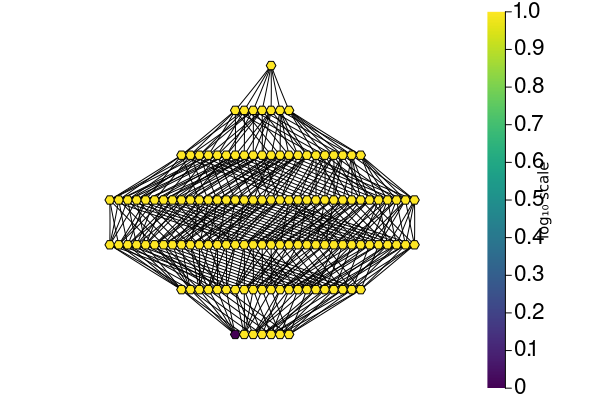

In [58]:
# Create graph
all_combinations = get_all_combinations(distribution_number)
vertice_dict = create_vertice_dictionary(all_combinations)

# Colors
nodes_color = assign_color_from_zscore(vertice_dict)
norm_color = color_norm.(0:255)

#Print graph
G, positions = create_ordonated_combination_graph(
    7,
    all_combinations,
    vertice_dict,
    )



# gplot(
#     G, 
#     positions[1,:], 
#     positions[2,:], 
#     nodefillc=nodes_color
#     )

gr()  # or pyplot(), plotly(), etc.
graphplot(
    G; 
    x           = positions[1,:],
    y           = positions[2,:],
    node_z      = norm_color,
    nodecolor   = :viridis,
    markersize  = 10,
    linecolor   = :black,
    arrow       = false,
    colorbar    = true,
    cbar_title  = "log₁₀ scale"
)